# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

В рамках работы над проектом мы проведем следующие этапы работы с данными: 

1) Исследовательский анализ данных

2) Обучение модели

3) Анализ обученной модели

Мы построим и обучим свёрточную нейронную сеть на датасете с фотографиями людей. По требованию заказчика необходимо, чтобы  значения MAE на тестовой выборке было не больше 8. Приступим! 

## Исследовательский анализ данных

In [1]:
#импортируем необходимые библиотеки:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#загрузим данные:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
#посмотрим размер выборки:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В выборке 7591 фотография. Посмотрим на график распределения возраста в выборке. 

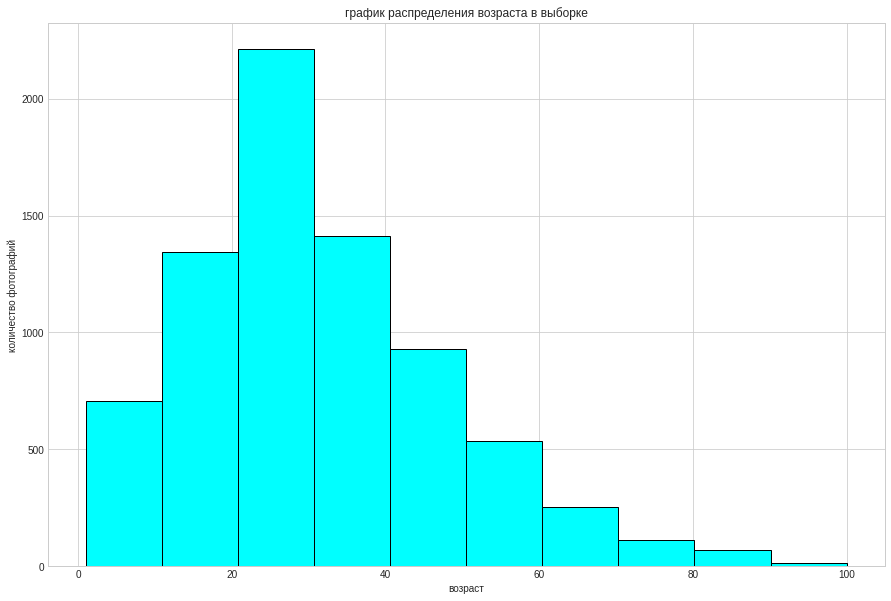

In [4]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15, 10))
plt.hist(labels['real_age'], bins=10,  color = 'cyan', edgecolor='black')
plt.title('график распределения возраста в выборке')
plt.xlabel('возраст')
plt.ylabel('количество фотографий')
plt.show()

В датасете выделились вполне "логичные" группы: людей в возрасте старше 80 лет крайне мало, больше всего фотографий людей возраста от 20 до 30. Детей и стариков- примерно равное количество. "Выбросы" не обнаружены. 

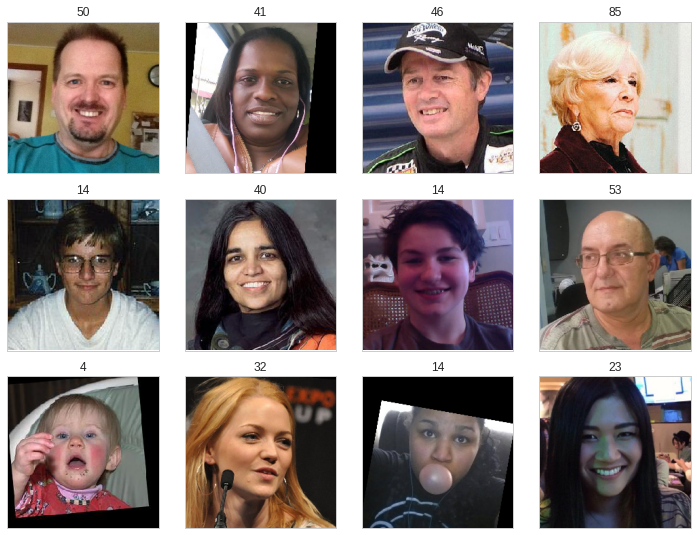

In [5]:
#Выведем на экран 12 изображений из 1 батча обучающей выборки:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**:

В датасете представлены самые разные фотографии, разного качества и "срока давности". Есть немного "повернутые" фотографии, меньшего размера, чем остальные (на черном фоне). Скорее всего, в датасете есть и черно-белые фотографии. 

Представленный возраст соответствует фото. В датасете учтены разные возрастные категории людей, и данных вполне достаточно для обучения. Можно предположить уже сейчас, что модель покажет хорошие результаты, обучившись на таком датасете. Поэтому мы не будем проводить аугментацию, а попробуем обучить модель на тех данных, что представлены изначально в датасете. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

#
< import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

def load_train(path):
    datagen_train = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = datagen_train.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224), 
                                                     batch_size=32, 
                                                     class_mode='raw', 
                                                     subset='training',
                                                     seed=12345)
    train_data = train_datagen_flow
    return train_data

def load_test(path):
    datagen_valid = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = datagen_valid.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name',
                                                     y_col='real_age', 
                                                     target_size=(224, 224), 
                                                     batch_size=32, 
                                                     class_mode='raw', 
                                                     subset='validation',
                                                     seed=12345)
    test_data = test_datagen_flow
    return test_data


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model >

```

```

# < Train for 178 steps, validate for 60 steps
Epoch 1/5
2022-07-05 17:51:50.554372: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-05 17:51:50.845591: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 224.1629 - mae: 10.6492 - val_loss: 1066.2545 - val_mae: 28.0475
Epoch 2/5
178/178 - 38s - loss: 58.9952 - mae: 5.8647 - val_loss: 933.5707 - val_mae: 25.6262
Epoch 3/5
178/178 - 38s - loss: 30.1608 - mae: 4.2116 - val_loss: 365.4591 - val_mae: 14.2300
Epoch 4/5
178/178 - 37s - loss: 18.9076 - mae: 3.3285 - val_loss: 115.0685 - val_mae: 8.2598
Epoch 5/5
178/178 - 37s - loss: 13.9395 - mae: 2.8872 - val_loss: 84.6362 - val_mae: 6.8830
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 84.6362 - mae: 6.8830
Test MAE: 6.8830 >
```

## Анализ обученной модели

Итак, мы построили и обучили свёрточную нейронную сеть на датасете с фотографиями людей. По требованию заказчика необходимо, чтобы значения MAE на тестовой выборке было не больше 8. Мы добились значения 6.88, то есть в среднем модель допускает ошибку при предсказании возраста в пределах 7 лет. Поэтому можно считать, что требование заказчика выполнено, и мы можем рекомендовать нашу модель для внедрения заказчику. 

Заказчик преследовал 2 цели: Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; Контролировать добросовестность кассиров при продаже алкоголя.

С 1 задачей модель справится успешно, а вот для второй задачи, скорее всего, нужна другая модель - бинарной классификации, которая делила бы людей на 2 группы: до 18 лет и старше 18 лет, при этом у такой модели должна быть очень высокая точность предсказания. 